In [1]:
## Standard libraries
import time
import json
import math
import numpy as np
import scipy
from scipy.linalg import fractional_matrix_power as frac_mat_pow
from datetime import datetime

## Imports for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## TensorFlow
import tensorflow as tf

def setup_gpu(seed=42):
    # Function for setting the seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Additionally, some operations on a GPU are implemented stochastic for efficiency
    # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Fetching the device that will be used throughout this notebook
    device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
    print("Using device -> ", device)



2023-12-22 07:15:03.891881: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 07:15:03.891947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 07:15:03.901101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 07:15:03.911973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 07:15:06.277652: W tensorflow/compiler/tf2

In [2]:
long_term_mean = 0.01
mean_reversion = 0.5
volitality = 0.001

def mu(X):
    return (long_term_mean - X) * mean_reversion

def varsigma(X):
    return torch.ones(X.shape[0]) * volitality

In [3]:
# N = 10
# T = 5
# d = 3
# Sigma = torch.eye(d)
# Lambda = 2
# memory = 0
# X = [] 
# Drift = []
# Diffusion = []
# input_output_pairs = []

# X.append(torch.zeros(N, d)) # X[-1]
# Drift.append(torch.zeros(N, d))
# Diffusion.append(torch.zeros(N, d))
# X.append(torch.zeros(N, d)) # X[0]
# Drift.append(torch.zeros(N, d)) 
# Diffusion.append(torch.zeros(N, d))

# t = 1
# Z = torch.randn(N, d) # N x d 
# B = torch.bernoulli(torch.tensor([0.5]*N)) # N 
# drift_t = memory * mu(X[t-2]) + (1-memory) * mu(X[t-1]) # N x d 
# S = torch.einsum("n,dk->ndk", (B * Lambda), torch.eye(d)) # N x d x d
# diffusion_t = S + torch.einsum("n,dk->ndk", varsigma(X[t-1]), Sigma) # N x d x d
# x_t = X[t-1] + drift_t + torch.einsum("nk,nkd->nd", Z, diffusion_t)

# X.append(x_t)
# Drift.append(drift_t)
# Diffusion.append(diffusion_t)

In [14]:
N = 1000
T = 1000
d = 1
Sigma = torch.eye(d)
Lambda = 1
memory = 0
X = [] 
Drift = []
Diffusion = []
input_output_pairs = []

In [15]:
for t in range(T+1):
    if t == 0:
        X.append(torch.zeros(N, d)) # X[-1]
        Drift.append(torch.zeros(N, d))
        Diffusion.append(torch.zeros(N, d, d))
        X.append(torch.zeros(N, d)) # X[0]
        Drift.append(torch.zeros(N, d)) 
        Diffusion.append(torch.zeros(N, d, d))
    else:
        Z = torch.randn(N, d) # N x d 
        B = torch.bernoulli(torch.tensor([0.5]*N)) # N 
        drift_t = memory * mu(X[t-2]) + (1-memory) * mu(X[t-1]) # N x d 
        S = torch.einsum("n,dk->ndk", (B * Lambda), torch.eye(d)) # N x d x d
        diffusion_t = S + torch.einsum("n,dk->ndk", varsigma(X[t-1]), Sigma) # N x d x d
        x_t = X[t-1] + drift_t + torch.einsum("nk,nkd->nd", Z, diffusion_t)
        X.append(x_t)
        Drift.append(drift_t)
        Diffusion.append(diffusion_t)
        

In [16]:
X_NTd = torch.stack(X, dim=1)
Drift_NTd = torch.stack(Drift, dim=1)
Diffusion_NTd = torch.stack(Diffusion, dim=1)

In [17]:
X = X_NTd[:, 0:, :]
Drift = Drift_NTd[:, 0:, :]
Diffusion = Diffusion_NTd[:, 0:, :]

In [8]:
# A = torch.linalg.matrix_power(torch.einsum("n,dk->ndk", torch.tensor([1,2,3,4]), torch.ones(3,3)), 2)
# print(A)
# print("Answer: \n",tf.cast(tf.linalg.sqrtm(tf.cast(A, tf.complex128)), tf.float64))
# # !!!! Not only it is not stable but also slow -> https://github.com/tensorflow/tensorflow/issues/58334

In [9]:
# First = torch.einsum("n,dk->ndk", torch.tensor([1,2,3,4]), torch.ones(3,3)) # N x d x d
# print("First : \n", First)
# Second = torch.ones(d,d) # d x d
# print("Second : \n", Second)
# print("Answer: \n", torch.einsum("ndk,lk->ndk", First, Second))

In [10]:
# A = torch.tensor([1,2,3,4])
# print(A)
# B = torch.einsum("n,dk->ndk", torch.tensor([1,2,3,4]), torch.ones(3,3))
# print(B)
# torch.einsum("n,ndk->ndk", A, B)


In [11]:
# torch.from_numpy(frac_mat_pow(First[0] , 1/2)).type(torch.FloatTensor) 

In [22]:
sigma_2 = torch.matrix_power(Sigma,2)
sigma_neg_2 = torch.matrix_power(torch.linalg.pinv(Sigma), 2)

start_time = datetime.now()

for t in range(1, T+2):
    x_t_1 = X[:, t-1, :]
    x_t = X[:, t, :]
    drift_t = Drift[:, t, :]

    mu_x_t =  x_t_1 + drift_t # N x d
    
    inner_power_arg = Lambda * torch.eye(d).reshape((1, d, d)).repeat(N, 1, 1) +  torch.einsum("n,dk->ndk", varsigma(x_t_1), Sigma) # N x d x d
    inner_power = torch.linalg.matrix_power(inner_power_arg, 2)

    outer_power_arg = torch.einsum("ndk,lk->ndk", inner_power, sigma_neg_2)
    
    outer_power = torch.from_numpy(tf.cast(tf.linalg.sqrtm(tf.cast(outer_power_arg, tf.complex128)), tf.float64).numpy()) # N x d x d    
    #!!!! Not only it is not stable but also slow -> https://github.com/tensorflow/tensorflow/issues/58334

    # # Old Method using numpy arrys and scypi
    # outer_power_arg = np.array(outer_power_arg)
    # outer_power = torch.from_numpy(np.array([frac_mat_pow(outer_power_arg[i] , 1/2) for i in range(outer_power_arg.shape[0])])).type(torch.FloatTensor) 
    
    outer_mul = torch.einsum("ndk,lk->ndk", outer_power, sigma_2) # N x d x d
    covariance = torch.einsum("n,ndk->ndk", varsigma(x_t_1), outer_mul)
    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


Duration: 0:00:02.272095


- ```OLD : Duration: 0:00:14.270555```
- ```T F : Duration: 0:00:00.708524```

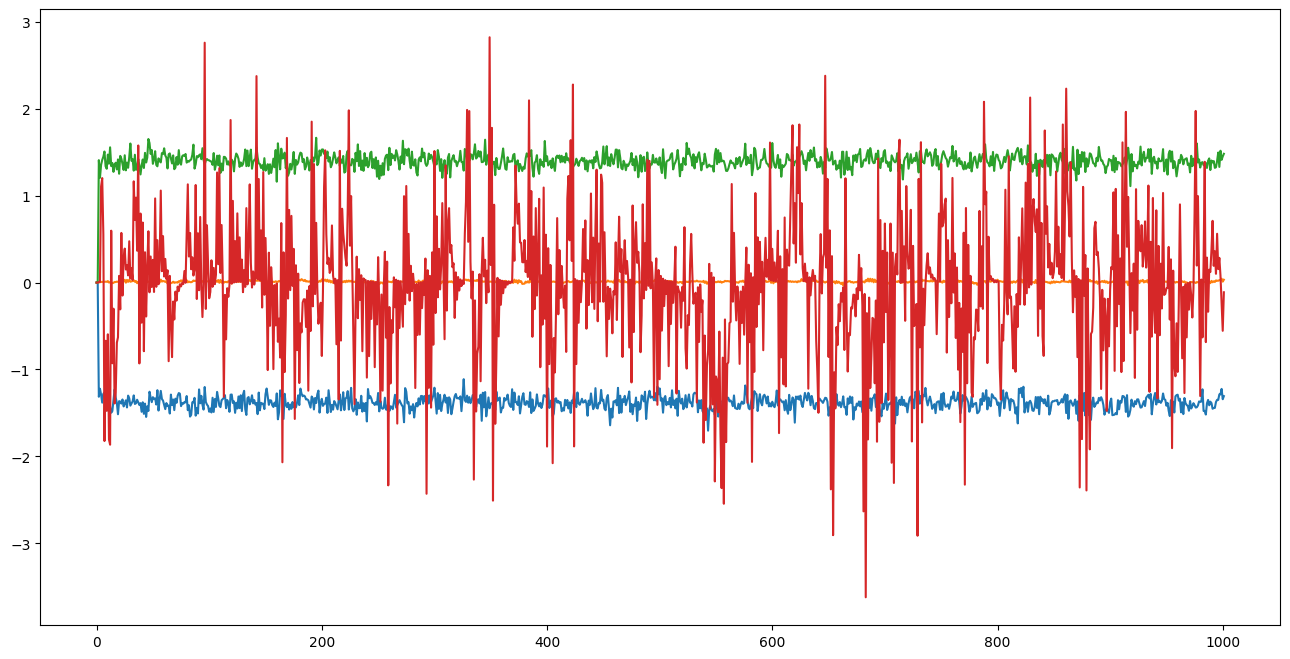

In [23]:
quantiles = torch.quantile(X, torch.tensor([0.05, 0.5, 0.95]), dim=0)
fig = plt.figure(figsize=(16,8))
plt.plot(quantiles[0])
plt.plot(quantiles[1])
plt.plot(quantiles[2])
plt.plot(X[0])